## Linear Programming

1. https://www.youtube.com/watch?v=7yZ5xxdkTb8
2. http://benalexkeen.com/linear-programming-with-python-and-pulp-part-1/


In [1]:
import numpy as np

import pulp
import pandas as pd
import re 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# x > 0
x = np.linspace(0, 20, 2000)
# y >= 2
y1 = (x*0) + 2
# 2y <= 25 - x
y2 = (25-x)/2.0
# 4y >= 2x - 8 
y3 = (2*x-8)/4.0
# y <= 2x - 5 
y4 = 2 * x -5


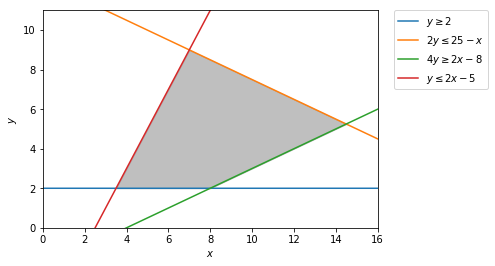

In [3]:
plt.plot(x, y1, label=r'$y\geq2$')
plt.plot(x, y2, label=r'$2y\leq25-x$')
plt.plot(x, y3, label=r'$4y\geq 2x - 8$')
plt.plot(x, y4, label=r'$y\leq 2x-5$')
plt.xlim((0, 16))
plt.ylim((0, 11))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
y5 = np.minimum(y2, y4)
y6 = np.maximum(y1, y3)
plt.fill_between(x, y5, y6, where=y5>y6, color='grey', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [4]:
# Now the same thing as pulp
lp_problem = pulp.LpProblem("My LP Problem", pulp.LpMaximize)
x = pulp.LpVariable('x', lowBound=0, cat='Continuous')
y = pulp.LpVariable('y', lowBound=2, cat='Continuous')
# Objective function
lp_problem += 4 * x + 3 * y, "Z"

# Constraints
lp_problem += 2 * y <= 25 - x
lp_problem += 4 * y >= 2 * x - 8
lp_problem += y <= 2 * x - 5

In [5]:
lp_problem

My LP Problem:
MAXIMIZE
4*x + 3*y + 0
SUBJECT TO
_C1: x + 2 y <= 25

_C2: - 2 x + 4 y >= -8

_C3: - 2 x + y <= -5

VARIABLES
x Continuous
2 <= y Continuous

In [6]:
lp_problem.solve()
pulp.LpStatus[lp_problem.status]

'Optimal'

In [7]:
for variable in lp_problem.variables():
    print("{} = {}".format(variable.name, variable.varValue))

x = 14.5
y = 5.25


In [8]:
print(pulp.value(lp_problem.objective))

73.75


In [21]:
books_df = pd.read_csv('../reading/sample_books.csv')

In [22]:
books_df.head()

,title,num_review,num_ratings,url,rating,num_pages,genres
0,to kill a mockingbird,75722,3504156,https://www.goodreads.com/book/show/2657.To_Ki...,4.26,324,"classics,fiction,historical"
1,of mice and men,26309,1592170,https://www.goodreads.com/book/show/890.Of_Mic...,3.85,112,"fiction,classics,academic"
2,the giver,56313,1382912,https://www.goodreads.com/book/show/3636.The_G...,4.12,208,"fiction,childrens,classics"
3,alice's adventures in wonderland & through the...,8160,389142,https://www.goodreads.com/book/show/24213.Alic...,4.06,239,"classics,fantasy,fiction"
4,the catcher in the rye,47062,2232015,https://www.goodreads.com/book/show/7933650-th...,3.80,230,"classics,fiction,young adult"


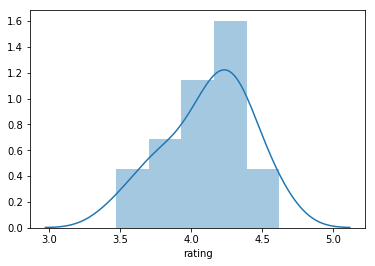

In [20]:
sns.distplot(books_df['rating'])

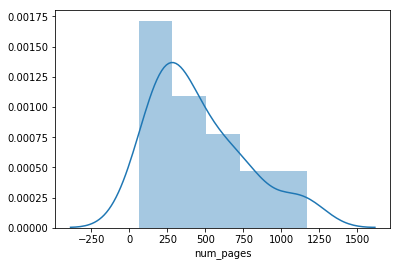

In [23]:
sns.distplot(books_df['num_
# create the LP object, set up as a maximization problem --> since we want to maximize the number of books we read in a year
prob = pulp.LpProblem('BuyingBestsellers', pulp.LpMaximize)pages'])

In [24]:
# create the LP object
# Maximization problem we want to maximize the number of books we read in 100 hours
prob = pulp.LpProblem('RecommendedBooks', pulp.LpMaximize)